# Basic regression: Predict fuel efficiency

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [102]:
import tensorflow as tf
import keras

print(tf.__version__)

2.16.2


## The Auto MPG dataset



In [103]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower',
                'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(
    url,
    names=column_names,
    na_values='?',
    comment='\t',
    sep=' ',
    skipinitialspace=True,
)

In [104]:
dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### Clean the data

In [105]:
dataset.shape

(398, 8)

In [106]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [107]:
dataset.dropna(inplace=True)

In [108]:
dataset['Origin'] = dataset['Origin'].map({
    1: 'USA',
    2: 'Europe',
    3: 'Japan',
})

In [109]:
dataset = pd.get_dummies(
    dataset,
    columns=['Origin'],
    prefix='',
    prefix_sep='',
)

In [110]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


### Split the data into training and test sets

In [111]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

In [112]:
train_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,28.0,4,90.0,75.0,2125.0,14.5,74,False,False,True
282,22.3,4,140.0,88.0,2890.0,17.3,79,False,False,True
69,12.0,8,350.0,160.0,4456.0,13.5,72,False,False,True
378,38.0,4,105.0,63.0,2125.0,14.7,82,False,False,True
331,33.8,4,97.0,67.0,2145.0,18.0,80,False,True,False


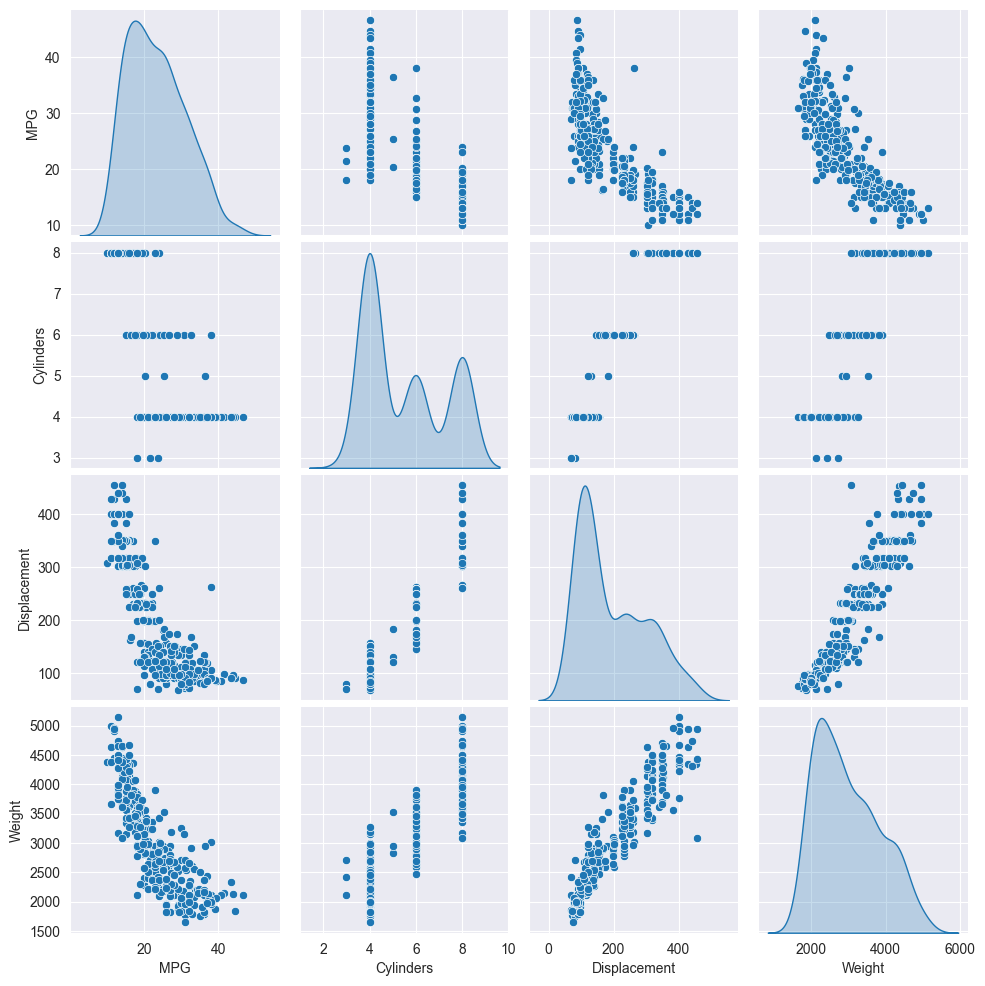

In [113]:
sns.pairplot(
    train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']],
    diag_kind='kde',
)

In [114]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


### Split features from the label

In [115]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalization

In [116]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


### The Normalization layer

In [117]:
normalizer = keras.layers.Normalization(axis=-1)

In [118]:
normalizer.adapt(np.array(train_features))

In [119]:
normalizer.mean.numpy()

array([[   5.478,  195.318,  104.869, 2990.252,   15.559,   75.898,
           0.178,    0.197,    0.624]], dtype=float32)

In [120]:
first = np.array(train_features[:1], dtype=np.float32)

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear regression

### Linear regression with one variable

In [121]:
horsepower = np.array(train_features['Horsepower'], dtype=np.float32)

horsepower_normalizer = keras.layers.Normalization(
    input_shape=[1,],
    axis=None,
)

horsepower_normalizer.adapt(horsepower)

/Users/stringydev/Developer/Projects/learning-tensorflow/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [122]:
horsepower_model = keras.Sequential([
    horsepower_normalizer,
    keras.layers.Dense(units=1),
])

horsepower_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_5 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [123]:
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


array([[ 0.273],
       [ 0.154],
       [-0.504],
       [ 0.383],
       [ 0.346],
       [ 0.136],
       [ 0.41 ],
       [ 0.346],
       [ 0.09 ],
       [ 0.154]], dtype=float32)

In [124]:
horsepower_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error',
)

In [125]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    validation_split=0.2,
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 22.4977 - val_loss: 22.9346
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.6498 - val_loss: 22.1346
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.6203 - val_loss: 21.3344
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.8216 - val_loss: 20.5346
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.1592 - val_loss: 19.7346
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.3392 - val_loss: 18.9345
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.1980 - val_loss: 18.1345
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.8358 - val_loss: 17.3345
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7041 - val_loss: 16.5345
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.7301 - val_loss: 15.7346
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.9061 - val_loss: 14.9348
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.6

In [126]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.815575,4.165983,95
96,3.804624,4.183655,96
97,3.803724,4.193346,97
98,3.805038,4.200429,98
99,3.802477,4.182320,99


In [127]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

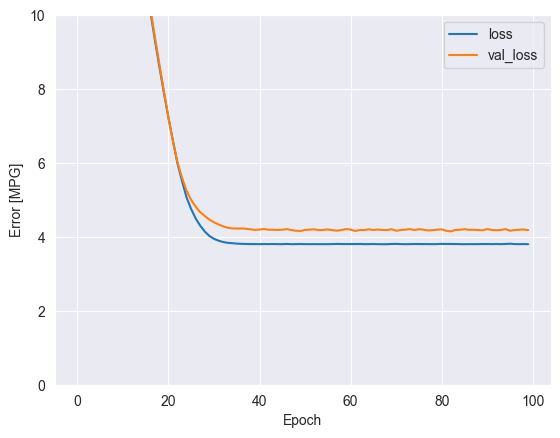

In [128]:
plot_loss(history)

In [129]:
test_results = {'horsepower_model': horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels,
)}

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5670


In [130]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [131]:
def plot_horsepower(x, y):
    plt.scatter(
        train_features['Horsepower'],
        train_labels,
        label='Data',
    )
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

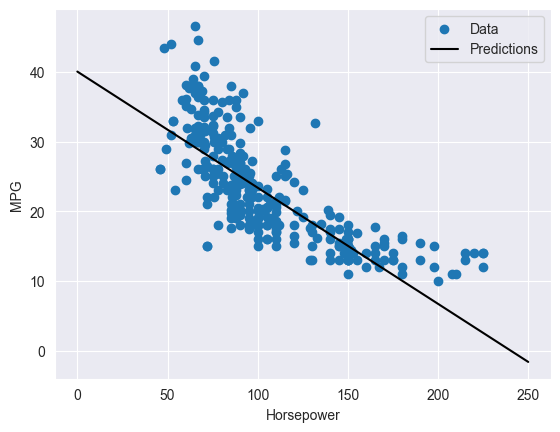

In [132]:
plot_horsepower(x, y)

## Linear regression with multiple inputs

In [133]:
linear_model = keras.Sequential([
    normalizer,
    keras.layers.Dense(units=1),
])

In [134]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


array([[-0.233],
       [-0.037],
       [-0.9  ],
       [-0.198],
       [-0.592],
       [ 0.473],
       [-0.248],
       [ 3.248],
       [ 0.321],
       [-0.47 ]], dtype=float32)

In [135]:
linear_model.layers[1].kernel

<KerasVariable shape=(9, 1), dtype=float32, path=sequential_8/dense_14/kernel>

In [136]:
linear_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [137]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    validation_split=0.2,
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 23.4313 - val_loss: 22.6600
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.5101 - val_loss: 21.9498
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.9006 - val_loss: 21.2280
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.6576 - val_loss: 20.5118
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.2389 - val_loss: 19.7873
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.5505 - val_loss: 19.0479
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.5736 - val_loss: 18.3135
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.0540 - val_loss: 17.5966
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.4812 - val_loss: 16.8822
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.2180 - val_loss: 16.1639
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.5945 - val_loss: 15.4495
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.9

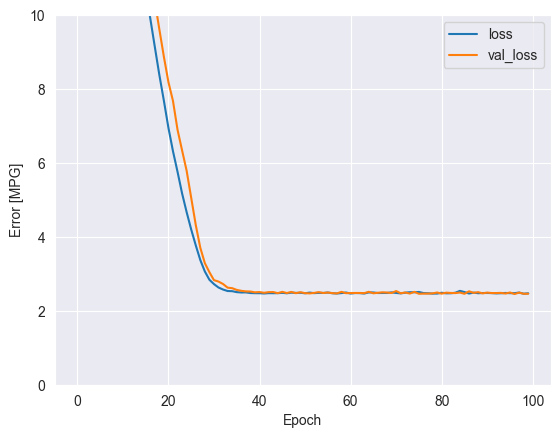

In [138]:
plot_loss(history)

In [139]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Regression with a deep neural network (DNN)

In [140]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1),
    ])

    model.compile(
        loss='mean_absolute_error',
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
    )

    return model

### Regression using a DNN and a single inputs

In [141]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [142]:
dnn_horsepower_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_5 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

In [143]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    epochs=100,
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 23.1028 - val_loss: 23.4442
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.2288 - val_loss: 23.1852
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.9335 - val_loss: 22.8991
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.1892 - val_loss: 22.5548
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.9719 - val_loss: 22.1087
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.5657 - val_loss: 21.5022
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.0058 - val_loss: 20.7027
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.7618 - val_loss: 19.6827
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.6594 - val_loss: 18.5022
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.2890 - val_loss: 17.2231
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3359 - val_loss: 15.9598
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.5

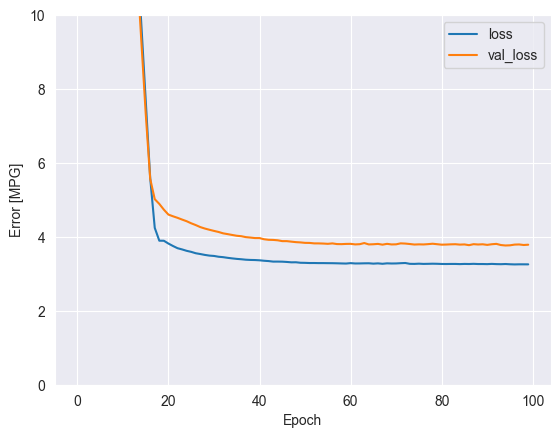

In [144]:
plot_loss(history)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


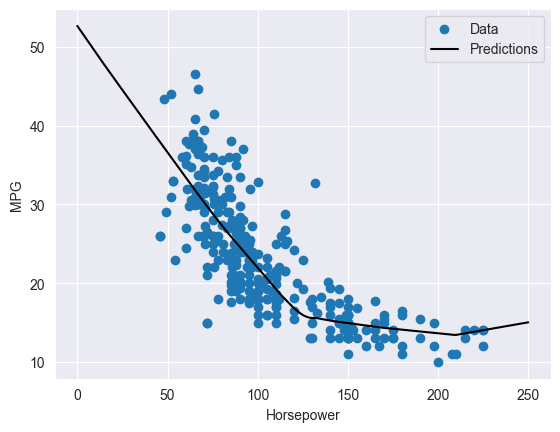

In [145]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

plot_horsepower(x, y)

In [146]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels,
)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7687


### Regression using a DNN and multiple inputs

In [147]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization) │ (10, 9)                │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [148]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    epochs=100,
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 22.8609 - val_loss: 23.1570
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.7560 - val_loss: 22.3490
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 22.4660 - val_loss: 21.4817
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.5939 - val_loss: 20.4464
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.8831 - val_loss: 19.1489
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.8705 - val_loss: 17.5469
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.2008 - val_loss: 15.9161
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.3079 - val_loss: 14.5987
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.0389 - val_loss: 12.9252
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.5465 - val_loss: 10.6793
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9707 - val_loss: 8.1716
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2773

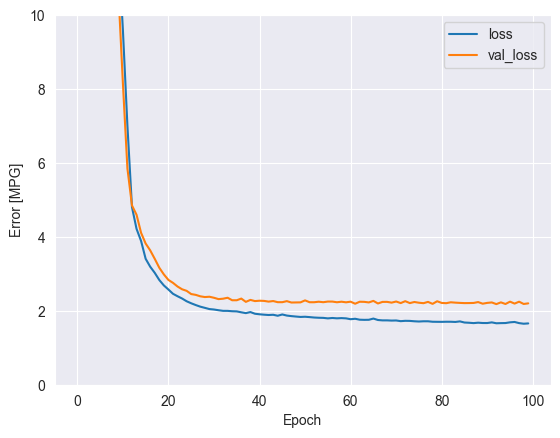

In [149]:
plot_loss(history)

In [150]:
test_results['dnn_model'] = dnn_model.evaluate(
    test_features,
    test_labels,
)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5621


## Performance

In [151]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.650279
linear_model,2.513560
dnn_horsepower_model,2.915502
dnn_model,1.673593


### Make predictions

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


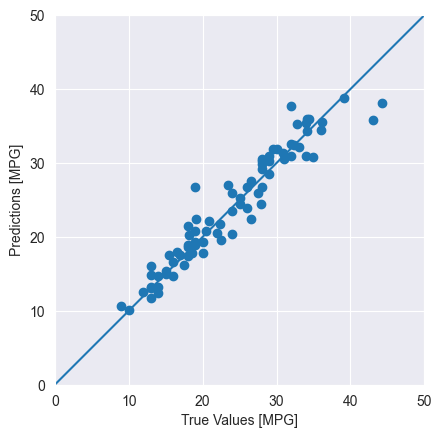

In [157]:
test_predictions = dnn_model.predict(test_features).flatten()

ax = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)

_ = plt.plot(lims, lims)

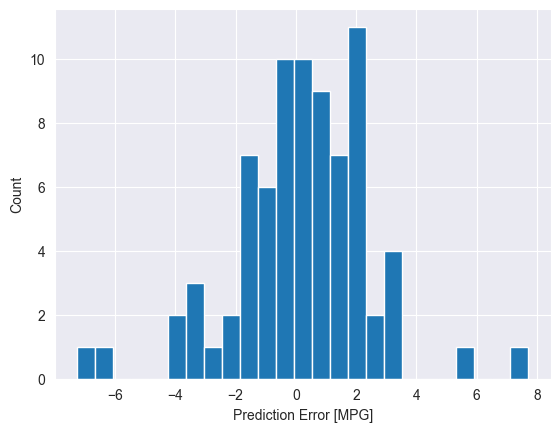

In [158]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [159]:
dnn_model.save('../models/dnn_model.keras')

In [161]:
reloaded = keras.models.load_model('../models/dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features,
    test_labels,
)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5621


In [162]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.650279
linear_model,2.513560
dnn_horsepower_model,2.915502
dnn_model,1.673593
reloaded,1.673593
